In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
from itertools import combinations 
from scipy.cluster import hierarchy
#import matplotlib.style
import matplotlib as mpl
import string
import re

import pvalannot
import heatmapannot

mplDefaultParams = mpl.rcParams

In [87]:
%load_ext autoreload
%autoreload 2

In [2]:
outputFig = True

In [4]:
# Check the diversity change between filtered and not filtered samples
def ComputeEntropy(rep):
    if (len(rep) == 0):
        return 0
    total = sum(list(rep.values()))
    return sum([-x/total*math.log(x/total) for x in rep.values()])

def ComputeClonality(rep):
    if (len(rep) < 1):
        return 0
    if (len(rep) == 1):
        if (sum(list(rep.values())) >= 3):
            return 1
        else: 
            return 0
    ret = 1 - ComputeEntropy(rep) / math.log(len(rep))
    if (ret < 1e-8):
        ret = 0
    return ret

def ComputeRichness(rep):
    return len(rep)

def ConvertToClonotypeFrequency(barcodeList):
    barcodeFreq = {}
    for barcode in barcodeList:
        if (barcode not in barcodeFreq):
            barcodeFreq[barcode] = 0
        barcodeFreq[barcode] += 1
    return barcodeFreq

def ParseCigar(cigar):
    cigarFields = re.findall("\d+\w", cigar)
    ret = []
    for f in cigarFields:
        ret.append( (int(f[0:-1]), f[-1]) )
    return ret

In [5]:
# Load the data set
folder="./"
#celltype = "bcell"
#celltype = "cd3_pos_cd4_neg"
#celltype = "cd3_pos_cd8_neg"
clusterName = {}
barcodeInfo = {}
poolToSelectedAttr = {}
for celltype in ["bcell", "cd3_pos_cd4_neg", "cd3_pos_cd8_neg"]:
    metaFile = folder + celltype + "_metadata.tsv"
    metaDf = pd.read_csv(metaFile, sep="\t", converters={"sample_id":str}) # important to have the converters
    selectedAttr = ["age", "genotype", "sample_id", "seurat_clusters", "annotation"]

    for i, row in metaDf.iterrows():
        barcodeInfo[i] = {}
        pool = i.split("-")[0]
        poolToSelectedAttr[pool] = {}
        for attr in selectedAttr:
            if (attr == "annotation"):
                continue
            barcodeInfo[i][attr] = str(row[attr])
            poolToSelectedAttr[pool][attr] = str(row[attr])
            
        # Special treatment to the annotation
        term = "new_annotation"
        attr = "annotation"
        if (term in row):
            barcodeInfo[i][attr] = row[term]
            poolToSelectedAttr[pool][attr] = row[term]
        else:
            barcodeInfo[i][attr] = row["seurat_clusters"]
            poolToSelectedAttr[pool][attr] = row["seurat_clusters"]
            
        barcodeInfo[i]["celltype"] = celltype
        globalClusterId = celltype + " " + str(row["seurat_clusters"])
        barcodeInfo[i]["global_cluster"] = globalClusterId
        barcodeInfo[i]["global_annotation"] = celltype + " " + \
                                str(barcodeInfo[i]["annotation"])
        if (globalClusterId not in clusterName):
            clusterName[globalClusterId] = 0
        clusterName[globalClusterId] += 1

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_98520/687609144.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  metaDf = pd.read_csv(metaFile, sep="\t", converters={"sample_id":str}) # important to have the converters


In [42]:
metaDf[ metaDf["genotype"]=="WT"]["orig.ident"].value_counts()

orig.ident
mouse262    761
mouse234    717
mouse257    671
mouse051    661
mouse189    588
mouse049    575
mouseD      434
mouse055    426
mouseC      377
mouse050    362
mouse219    341
mouse129    321
mouse010    289
mouse207    255
mouse118    199
mouse113    186
mouse217    176
mouse115     69
Name: count, dtype: int64

In [ ]:
# Load the immune repertoire
file = folder + "trust4_combined_barcoderep_filter.tsv"
fp = open(file)
header = fp.readline()
ambientBarcodeInfo = {}
# Use 2 for heavy chain/TRB, 3 for light chain/TRA
chainField = 2
for line in fp:
    cols = line.rstrip().split()
    if (cols[chainField] == "*"):
        continue   
    barcode = cols[0]
    
    chainCols = cols[chainField].split(",") 
    if ("_" in chainCols[5] or "?" in chainCols[5]):
        continue
    celltype = barcodeInfo[barcode]["celltype"]
    typeSet = set({"B"})
    if (celltype == "cd3_pos_cd4_neg" or celltype == "cd3_pos_cd8_neg"):
        typeSet = set({"abT", "gdT"})
    if (cols[1] not in typeSet):
        continue
    barcodeInfo[barcode]["type"] = cols[1]
    barcodeInfo[barcode]["CDR3nt"] = chainCols[4]
    barcodeInfo[barcode]["CDR3aa"] = chainCols[5]
    barcodeInfo[barcode]["V"] = chainCols[0]
    barcodeInfo[barcode]["J"] = chainCols[2]
    barcodeInfo[barcode]["C"] = chainCols[3].split("*")[0]
fp.close()

file = folder + "trust4_combined_barcode_airr.tsv"
fp = open(file)
for line in fp:
    cols = line.rstrip().split("\t")
    barcode = "_".join(cols[0].split("_")[:-1])
    if (barcode not in barcodeInfo or "type" not in barcodeInfo[barcode]):
        continue 
    if (cols[12] != barcodeInfo[barcode]["CDR3nt"]):
        continue
    barcodeInfo[barcode]["sequence_alignment"] = cols[8]
    barcodeInfo[barcode]["germline_alignment"] = cols[9]
    completeVdj = cols[20]
    if (cols[20] == 'T'):
        # refine it.
        vCigar = cols[14]
        jCigar = cols[16]
        vfields = ParseCigar(vCigar)
        if ((len(vfields) >= 2 and vfields[0][1] == 'S' and vfields[1][1] == 'N')
           or vfields[0][1] == 'N'):
            completeVdj = False
        jfields = ParseCigar(jCigar)
        if ((len(jfields) >= 2 and jfields[-1][1] == 'S' and jfields[-2][1] == 'N')
           or jfields[-1][1] == 'N'):
            completeVdj = False
   
    vlevel = 0 # 0: incomplete V, 1: completeV, 2: completeVDJ
    if (completeVdj == 'T'):
        vlevel = 2 
    elif (cols[14] != ""):
        vCigar = cols[14]
        vfields = ParseCigar(vCigar)
        k = 0
        vMissing = [0, 0]
        matches = 0
        for f in vfields:
            if (f[1] != 'S' and f[1] != 'N'):
                k = 1
                if (f[1] == 'M'):
                    matches += f[0]
            elif (f[1] == 'N'):
                vMissing[k] = f[0]
        if (vMissing[0] == 0 and matches > 250):
            vlevel = 1
    barcodeInfo[barcode]["complete_vdj"] = completeVdj
    barcodeInfo[barcode]["v_completeness"] = vlevel
fp.close()

barcodeDf = pd.DataFrame.from_dict(barcodeInfo, orient="index")
#typeSet = set({"B"})
#if (celltype == "cd3_pos_cd4_neg" or celltype == "cd3_pos_cd8_neg"):
#    typeSet = set({"abT", "gdT"})
#barcodeDf = barcodeDf.loc[barcodeDf["type"].isin(typeSet)]

In [ ]:
# Associate clonotye with meta information
#for barcode in barcodeInfo:
#    if ("type" not in barcodeInfo[barcode]):
#        barcodeInfo[barcode]["type"] = "."
#        barcodeInfo[barcode]["CDR3nt"] = "."
#        barcodeInfo[barcode]["CDR3aa"] = "."


#barcodeDf = pd.DataFrame.from_dict(barcodeInfo, orient="index")
barcodeDf.to_csv( "trust4_with_meta.tsv", sep="\t")

In [23]:
sampleClusterCdr3List = {}
sampleClusterInfo = {}
cdr3Type = "CDR3aa"
for barcode in barcodeInfo:
    sampleCluster = "mouse" + str(barcodeInfo[barcode]["sample_id"]) + " " \
                  + barcodeInfo[barcode]["global_annotation"]
    pool = barcode.split("-")[0]
    if (sampleCluster not in sampleClusterInfo):
        sampleClusterCdr3List[sampleCluster] = []
        sampleClusterInfo[sampleCluster] = {}
        sampleClusterInfo[sampleCluster]["age"] = barcodeInfo[barcode]["age"]
        sampleClusterInfo[sampleCluster]["genotype"] = barcodeInfo[barcode]["genotype"]
        sampleClusterInfo[sampleCluster]["id"] = str(barcodeInfo[barcode]["sample_id"])
        sampleClusterInfo[sampleCluster]["celltype"] = barcodeInfo[barcode]["celltype"]
        sampleClusterInfo[sampleCluster]["cluster"] = barcodeInfo[barcode]["seurat_clusters"]
        sampleClusterInfo[sampleCluster]["annotation"] = barcodeInfo[barcode]["annotation"]
        sampleClusterInfo[sampleCluster]["size"] = 0
    sampleClusterInfo[sampleCluster]["size"] += 1
    if (cdr3Type not in barcodeInfo[barcode]):
        continue
    sampleClusterCdr3List[sampleCluster].append(barcodeInfo[barcode][cdr3Type])
        

for sampleCluster in sampleClusterCdr3List:
    cdr3Freq = ConvertToClonotypeFrequency(sampleClusterCdr3List[sampleCluster])
    sampleClusterInfo[sampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
    sampleClusterInfo[sampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
    sampleClusterInfo[sampleCluster]["richness"] = ComputeRichness(cdr3Freq)
    sampleClusterInfo[sampleCluster]["count"] = sum(cdr3Freq.values())
sampleClusterDf = pd.DataFrame.from_dict(sampleClusterInfo, orient="index")
sampleClusterDf = sampleClusterDf[ sampleClusterDf["count"] >= 3 ]

In [ ]:
sorted(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["cluster"].unique())

In [ ]:
# metric split by samples
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
celltype = "bcell" 
#celltype = "cd3_pos_cd4_neg"
#celltype = "cd3_pos_cd8_neg"
#celltype = "ambient"
#clusterCnt = max(list(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["cluster"])) + 1
colors = sns.color_palette("bright", len(genotypes))
xorder = []
if (celltype != "ambient"):
    xorder = sorted(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["annotation"].unique(),
                   key = lambda x: (int(re.split("[A-Za-z_]+", x)[0]), 
                                    re.split("[0-9]+", x)[1]))
else:
    xorder = [-1]
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))
for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.2)
    fig, axes = plt.subplots(4, 1, figsize=(10, 15))
    for axIdx, age in enumerate(ages):
        df = sampleClusterDf.loc[(sampleClusterDf["celltype"] == celltype) &
                                (sampleClusterDf["age"] == age)]
        ax = axes[axIdx]
        mypalette = sns.color_palette("bright", len(genotypes))
        if (age == "sick"):
            mypalette = mypalette[1:]
        snsFig = sns.boxplot(x = "annotation", y=metric, data=df, hue="genotype", ax=ax, order=xorder,
                    hue_order = genotypes, showfliers = False, palette="bright")
        
        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                 snsFig.lines[j].set_color(color)
        
        handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='annotation', y=metric, data=df, hue="genotype", 
                     ax = ax, dodge=True, order=xorder, hue_order = genotypes, 
                     palette = "bright", size=3.5)
        ax.set(title=age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        
        #if (axIdx == 3):
        #    ax.legend(handles=legend_elements, loc="center left",
        #             bbox_to_anchor=(1, 0.5))     
            
        pairs = []
        tmp = 0
        for c in df["annotation"].unique():
            for i in range(len(genotypes) - 1):
                if (i == 0 and age == "sick"):
                    continue
                pairs.append([(c, genotypes[i]), (c,genotypes[3])])
            pairs.append([(c,genotypes[1]), (c,genotypes[2])])
            if (age != "sick"):
                pairs.append([(c,genotypes[0]), (c,genotypes[2])])
            tmp += 1
                
        pvalannot.AddPvalAnnot(x="annotation", hue = "genotype", y=metric, 
                     data=df,order=xorder, hue_order = genotypes, font_scale=1,
                     pairs=pairs, ax=ax, fig=fig, fmt="%.0e", styles = ["hide_nonsig"])
        #ax.set_xticklabels(labels = [str(i) for i in xorder])
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
        if (axIdx == 0):
            fig.legend(handles, labels, loc="lower right", ncol=4, 
                     bbox_to_anchor = (1, 1))
        ax.legend([], [], frameon=False)
        ax.set(xlabel="")
        if (axIdx != len(ages) - 1):
            ax.set_xticks([])
        #ax.legend(handles=legend_elements, loc="upper right")
        #ax.legend(loc="upper right")
    #plt.title(celltype)
    plt.tight_layout()    
    if (True):
        #plt.savefig("in_prog/" + celltype + "_" + metric + "_wpval.pdf", format="pdf")
        plt.savefig("./" + celltype + "_" + metric + ".pdf", format="pdf") 

In [ ]:
# metric between clusters without any split
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
celltype = "bcell" 
#celltype = "cd3_pos_cd4_neg"
#celltype = "cd3_pos_cd8_neg"

#clusterCnt = max(list(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["cluster"])) + 1
colors = sns.color_palette("bright", len(genotypes))
xorder = []
if (celltype != "ambient"):
    xorder = sorted(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["annotation"].unique(),
                   key = lambda x: (int(re.split("[A-Za-z_]+", x)[0]), 
                                    re.split("[0-9]+", x)[1]))
else:
    xorder = [-1]
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))
for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="whitegrid", font_scale=1.2)
    fig, axes = plt.subplots(3, 1, figsize=(10, 20))
    for axIdx, celltype in enumerate(["bcell", "cd3_pos_cd4_neg", "cd3_pos_cd8_neg"]):
        df = sampleClusterDf.loc[(sampleClusterDf["celltype"] == celltype)]
        ax = axes[axIdx]
        mypalette = sns.color_palette("bright", len(genotypes))
        
            
        #xorder = sorted(df["annotation"].unique(),
        #           key = lambda x: (int(re.split("[A-Za-z_]+", x)[0]), 
        #                            re.split("[0-9]+", x)[1]))
        xorder = list(df.groupby("annotation").median([metric])[metric].sort_values().index) 
        snsFig = sns.boxplot(x = "annotation", y=metric, data=df, ax=ax, order=xorder,
                    showfliers = False, palette="bright")
        
        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                 snsFig.lines[j].set_color(color)
        
        handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='annotation', y=metric, data=df, 
                     ax = ax, dodge=False, order=xorder, 
                     palette = "bright", size=3.5)
        ax.set(title=celltype)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        
        #if (axIdx == 3):
        #    ax.legend(handles=legend_elements, loc="center left",
        #             bbox_to_anchor=(1, 0.5))     
        pairs = []
        for i,j in zip(xorder[0:len(xorder)-1], xorder[1:]):
            pairs.append([i,j])
        pvalannot.AddPvalAnnot(x="annotation", y=metric, 
                     data=df,order=xorder, hue_order = genotypes, font_scale=1,
                     pairs=pairs, ax=ax, fig=fig, fmt="%.0e") #styles = ["hide_nonsig"])
        #ax.set_xticklabels(labels = [str(i) for i in xorder])
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
        if (axIdx == 0):
            fig.legend(handles, labels, loc="lower right", ncol=4, 
                     bbox_to_anchor = (1, 1))
        ax.legend([], [], frameon=False)
        #ax.set(xlabel="")
        #if (axIdx != len(ages) - 1):
        #    ax.set_xticks([])
        #ax.legend(handles=legend_elements, loc="upper right")
        #ax.legend(loc="upper right")
    #plt.title(celltype)
    plt.tight_layout()    
    if (True):
        #plt.savefig("in_prog/" + celltype + "_" + metric + "_wpval.pdf", format="pdf")
        plt.savefig("./clusteronly_" + metric + ".pdf", format="pdf") 

In [ ]:
import pvalannot
# metric between clusters without any split
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
celltype = "bcell" 
#celltype = "cd3_pos_cd4_neg"
#celltype = "cd3_pos_cd8_neg"
#celltype = "ambient"
#clusterCnt = max(list(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["cluster"])) + 1
colors = sns.color_palette("bright", len(genotypes))
xorder = []
if (celltype != "ambient"):
    xorder = sorted(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["annotation"].unique(),
                   key = lambda x: (int(re.split("[A-Za-z_]+", x)[0]), 
                                    re.split("[0-9]+", x)[1]))
else:
    xorder = [-1]
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))
for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="whitegrid", font_scale=1.2)
    fig, axes = plt.subplots(3, 1, figsize=(10, 20))
    for axIdx, celltype in enumerate(["bcell"]):
        df = sampleClusterDf.loc[(sampleClusterDf["celltype"] == celltype)]
        ax = axes[axIdx]
        mypalette = sns.color_palette("bright", len(genotypes))
        
            
        #xorder = sorted(df["annotation"].unique(),
        #           key = lambda x: (int(re.split("[A-Za-z_]+", x)[0]), 
        #                            re.split("[0-9]+", x)[1]))
        xorder = list(df.groupby("cluster").median([metric])[metric].sort_values().index) 
        xorder = ["7", "15", "8",
                 "22", "0"]
        #df = df[ df["annotation"].isin(xorder)]
        snsFig = sns.boxplot(x = "annotation", y=metric, data=df, ax=ax, order=xorder,
                    showfliers = False, palette="bright")

        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                 snsFig.lines[j].set_color(color)
        
        handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='cluster', y=metric, data=df, 
                     ax = ax, dodge=False, order=xorder, 
                     palette = "bright", size=3.5)
        ax.set(title=celltype)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        
        #if (axIdx == 3):
        #    ax.legend(handles=legend_elements, loc="center left",
        #             bbox_to_anchor=(1, 0.5))     
                
        tests = pvalannot.AddPvalAnnot(x="cluster", y=metric, 
                     data=df,order=xorder, font_scale=1,
                     ax=ax, fmt="%.0e", styles = ["hide_nonsig"])
        #print(tests)
        #ax.set_xticklabels(labels = [str(i) for i in xorder])
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
        if (axIdx == 0):
            fig.legend(handles, labels, loc="lower right", ncol=4, 
                     bbox_to_anchor = (1, 1))
        ax.legend([], [], frameon=False)
        #ax.set(xlabel="")
        #if (axIdx != len(ages) - 1):
        #    ax.set_xticks([])
        #ax.legend(handles=legend_elements, loc="upper right")
        #ax.legend(loc="upper right")
    #plt.title(celltype)
    plt.tight_layout()    
    if (False):
        #plt.savefig("in_prog/" + celltype + "_" + metric + "_wpval.pdf", format="pdf")
        plt.savefig("./clusteronly_" + metric + "_completevdjonly.pdf", format="pdf") 

In [11]:
# Output raw data to a excel file
sampleClusterDf.to_excel("sample_cluster_diversity.xlsx")

In [24]:
sampleCellTypeCdr3List = {}
sampleCellTypeInfo = {}
cdr3Type = "CDR3aa"
for barcode in barcodeInfo:
    pool = barcode.split("-")[0]
    sampleCellType = str(barcodeInfo[barcode]["sample_id"]) + " " + barcodeInfo[barcode]["celltype"]
    if (sampleCellType not in sampleCellTypeInfo):
        sampleCellTypeCdr3List[sampleCellType] = []
        sampleCellTypeInfo[sampleCellType] = {}
        sampleCellTypeInfo[sampleCellType]["age"] = barcodeInfo[barcode]["age"]
        sampleCellTypeInfo[sampleCellType]["genotype"] = barcodeInfo[barcode]["genotype"]
        sampleCellTypeInfo[sampleCellType]["id"] = str(barcodeInfo[barcode]["sample_id"])
        sampleCellTypeInfo[sampleCellType]["celltype"] = barcodeInfo[barcode]["celltype"]
        sampleCellTypeInfo[sampleCellType]["cluster"] = barcodeInfo[barcode]["seurat_clusters"]
        sampleCellTypeInfo[sampleCellType]["size"] = 0
        sampleCellTypeCdr3List[sampleCellType] = []
    sampleCellTypeInfo[sampleCellType]["size"] += 1
    if (cdr3Type not in barcodeInfo[barcode]):
        continue
    sampleCellTypeCdr3List[sampleCellType].append(barcodeInfo[barcode][cdr3Type])
        
for sampleCellType in sampleCellTypeCdr3List:
    cdr3Freq = ConvertToClonotypeFrequency(sampleCellTypeCdr3List[sampleCellType])
    sampleCellTypeInfo[sampleCellType]["clonality"] = ComputeClonality(cdr3Freq)
    sampleCellTypeInfo[sampleCellType]["entropy"] = ComputeEntropy(cdr3Freq)
    sampleCellTypeInfo[sampleCellType]["richness"] = ComputeRichness(cdr3Freq)
    sampleCellTypeInfo[sampleCellType]["count"] = sum(cdr3Freq.values())
sampleCellTypeDf = pd.DataFrame.from_dict(sampleCellTypeInfo, orient="index")
sampleCellTypeDf = sampleCellTypeDf[ sampleCellTypeDf["count"] >= 3 ]

In [25]:
sampleCellTypeDf

,age,genotype,id,celltype,cluster,size,clonality,entropy,richness,count
234 bcell,6mos,WT,234,bcell,1,3045,0.004680,6.909667,1035,1069
257 bcell,6mos,WT,257,bcell,12,2923,0.000870,6.698580,816,825
010 bcell,6mos,WT,010,bcell,2,2076,0.000629,7.006806,1109,1122
C bcell,6mos,WT,C,bcell,9,1411,0.001692,6.374391,593,600
D bcell,6mos,WT,D,bcell,9,2284,0.002074,6.107603,455,464
...,...,...,...,...,...,...,...,...,...,...
200 cd3_pos_cd8_neg,sick,Bcl6tg/+,200,cd3_pos_cd8_neg,7,1219,0.798619,0.742871,40,715
021 cd3_pos_cd8_neg,sick,CD70-/-;Bcl6tg/+,021,cd3_pos_cd8_neg,8,345,0.209858,2.283806,18,43
107 cd3_pos_cd8_neg,sick,CD70-/-;Bcl6tg/+,107,cd3_pos_cd8_neg,12,563,0.033203,4.224367,79,95
041 cd3_pos_cd8_neg,sick,CD70-/-;Bcl6tg/+,041,cd3_pos_cd8_neg,3,932,0.515230,1.845357,45,223


In [14]:
sampleCellTypeDf.to_excel("sample_celltype_diversity.xlsx")

In [ ]:
# metric split by samples
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
genotypesId = {"WT":0, "CD70-/-":1, "Bcl6tg/+":2, "CD70-/-;Bcl6tg/+":3}
#celltype = "bcell" 
#celltype = "cd3_pos_cd4_neg"
celltype = "cd3_pos_cd8_neg"
#clusterCnt = max(list(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["cluster"])) + 1

# Legend for the barplot
colors = sns.color_palette("bright", len(genotypes))
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))

def SortDf(x):
    if (x.name == "genotype"):
        return x.apply(lambda y: genotypesId[y])
    else:
        return x
    
for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(4, 1, figsize=(20, 20))
    for axIdx, age in enumerate(ages):
        df = sampleCellTypeDf.loc[(sampleCellTypeDf["celltype"] == celltype) &
                                (sampleCellTypeDf["age"] == age)]
        df = df.sort_values(by=["genotype", metric], 
                            key=SortDf)
        ax = axes[axIdx]
        snsFig = sns.barplot(x = "id", y=metric, data=df, color="red", ax=ax, 
                   palette="bright")
        colors = sns.color_palette("bright", len(genotypes))
        for i,box in enumerate([p for p in snsFig.patches]): 
            box.set_edgecolor(colors[ genotypesId[df.iloc[i]["genotype"]] ])
            box.set_facecolor(colors[ genotypesId[df.iloc[i]["genotype"]] ])
        #    print("hi")
        #    iterate over whiskers and median lines
        #   for j in range(5*i,5*(i+1)):
        #         snsFig.lines[j].set_color(colors[i%len(genotypes)])
        
        #handles, labels = ax.get_legend_handles_labels()
        #sns.stripplot(x='id', y=metric, data=df, hue="genotype", 
        #             ax = ax, dodge=True, 
        #             palette = "bright", size=3.5)
        
        ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 0):
            ax.legend(handles=legend_elements, loc="upper right")
        #ax.legend(loc="upper right")
    #plt.title(celltype)
    plt.tight_layout()    
    if (True):
        plt.savefig("SampleCelltype/" + celltype + "_" + metric + "_SampleCelltype.pdf", format="pdf")
        
        

In [ ]:
import importlib
importlib.reload(pvalannot)

/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_98520/3567696006.py:38: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='genotype', y=metric, data=df,
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_98520/3567696006.py:38: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='genotype', y=metric, data=df,
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_98520/3567696006.py:38: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='genotype', y=metric, data=df,
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_98520/3567696006.py:38: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='genotype', y=metric, data=df,
/var/folders/c8/zsnj8w1x221_yh1cvqwq68n80000gn/T/ipykernel_98520/3567696006.py:38: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='genotype',

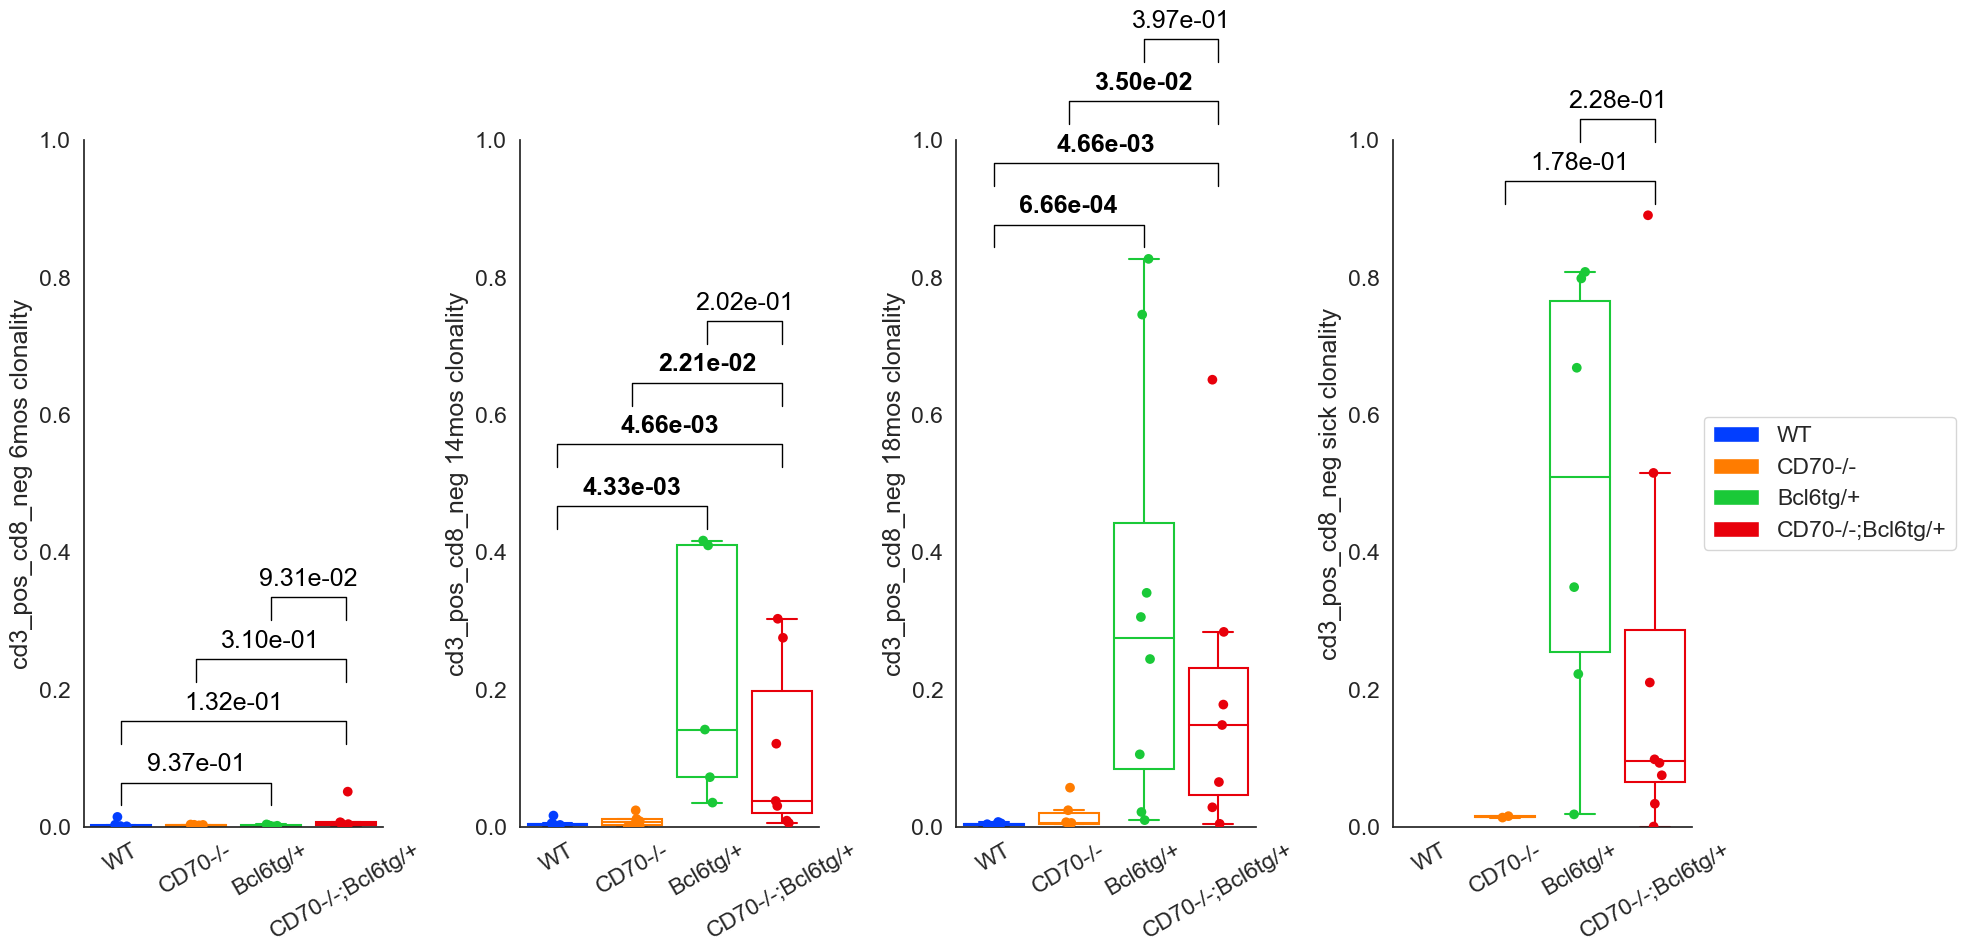

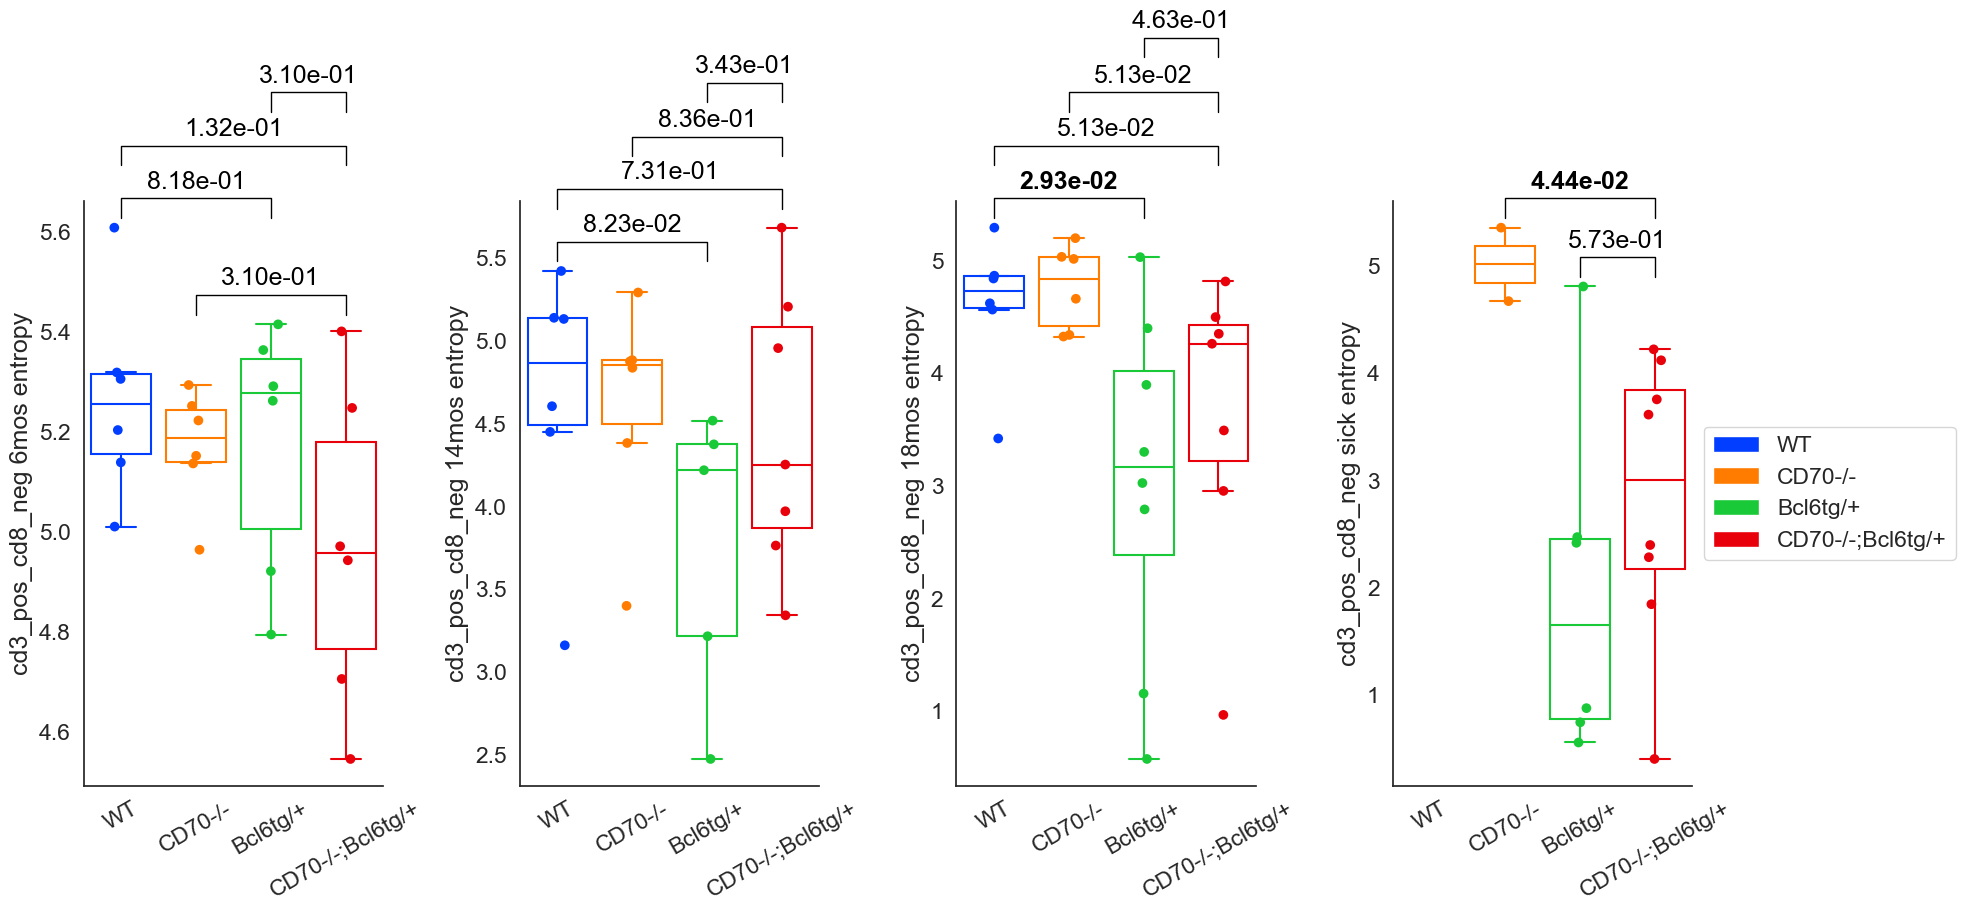

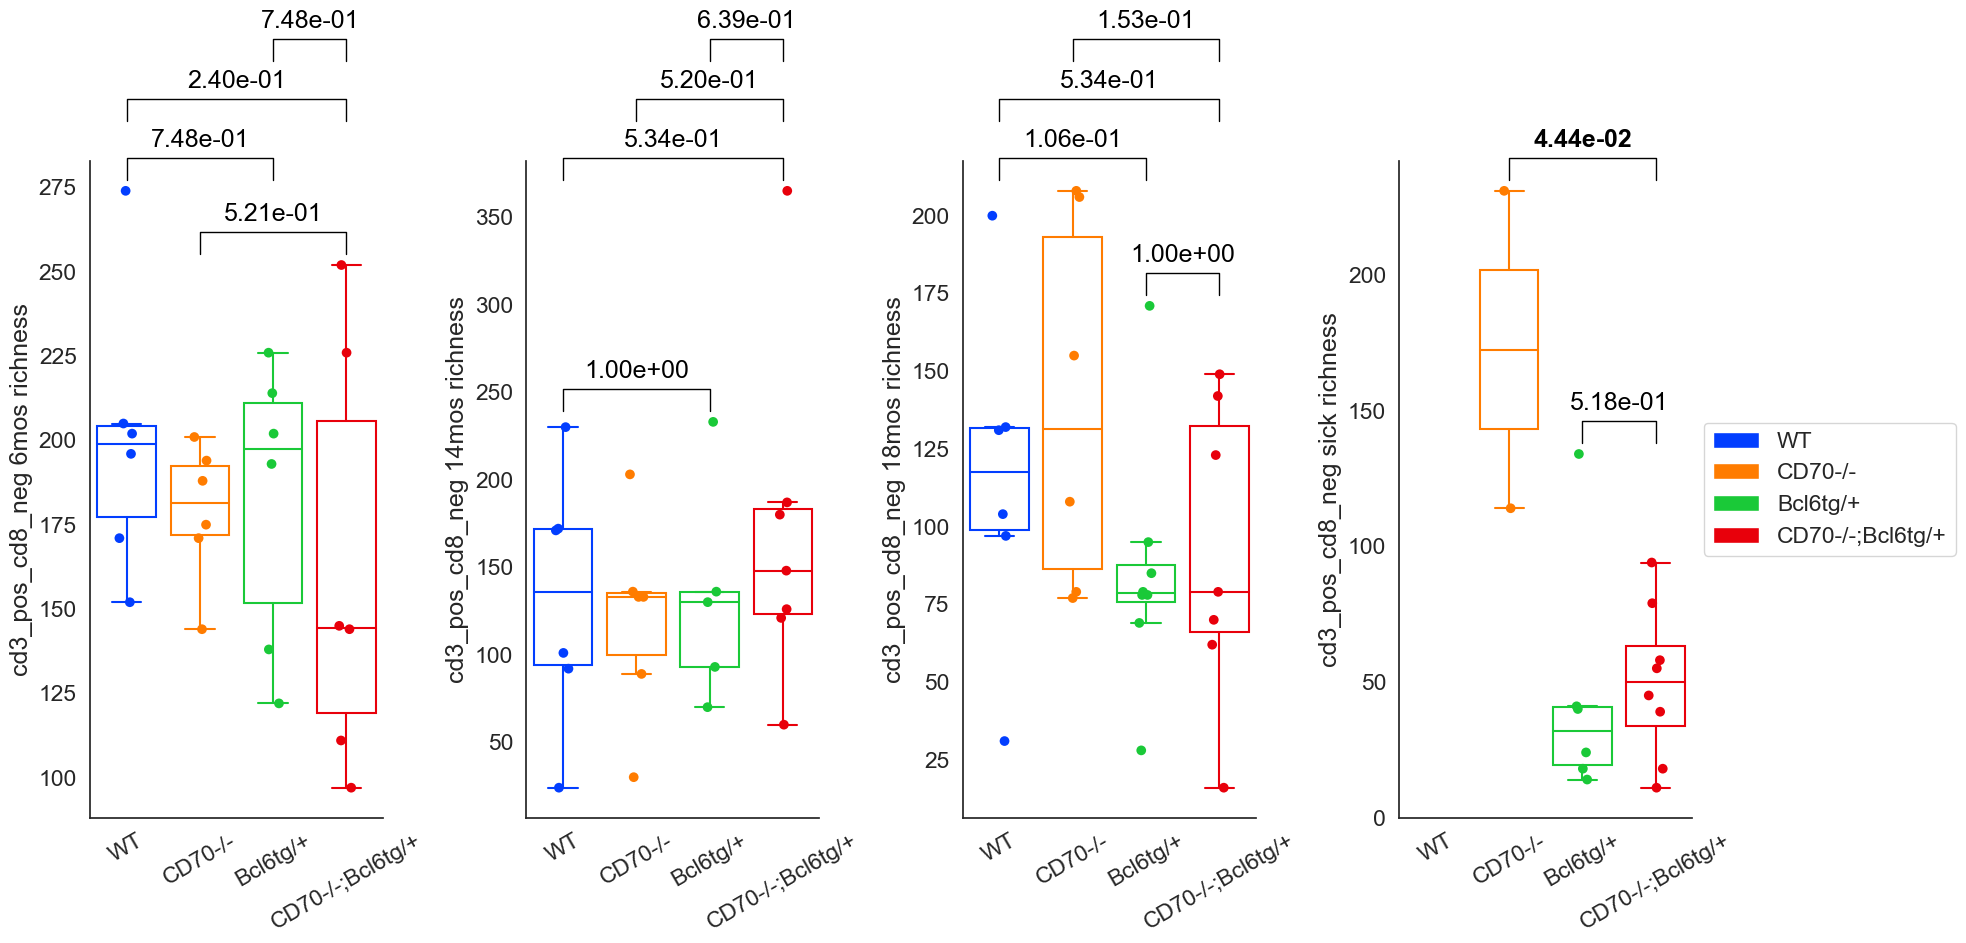

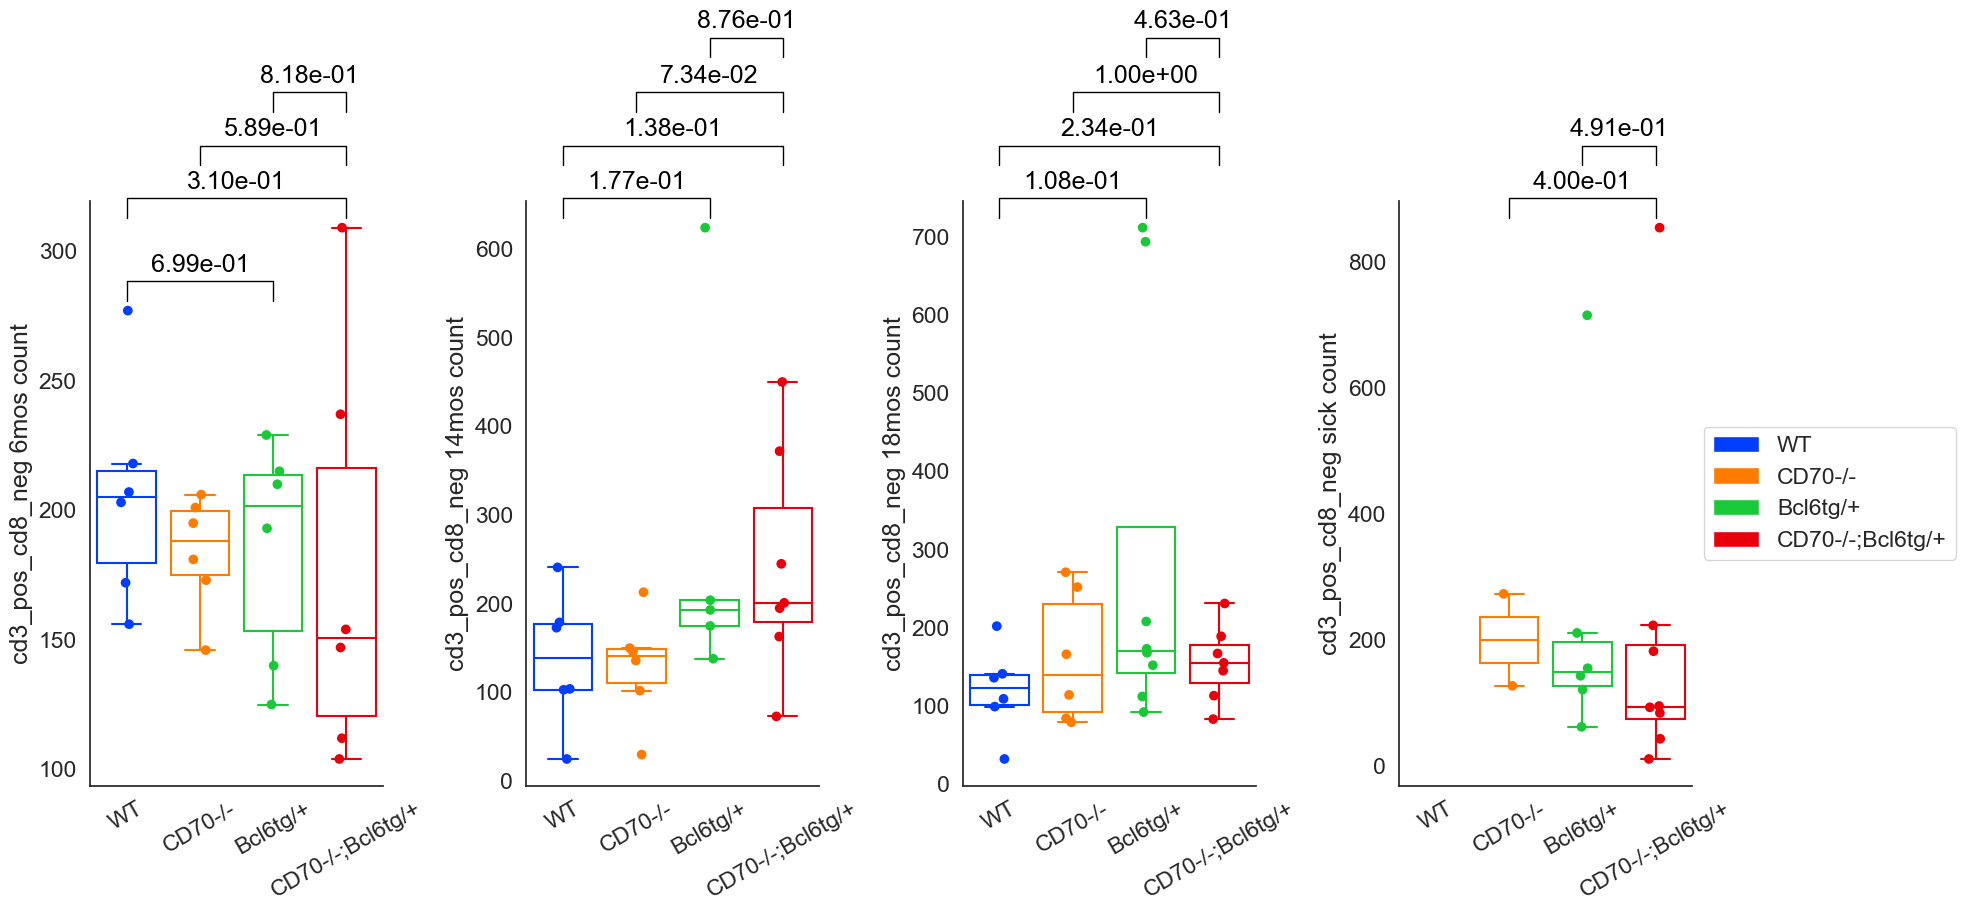

In [ ]:
# metric split by samples, shown in box plots, x-axis by genotype. do statistical comparison
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
genotypesId = {"WT":0, "CD70-/-":1, "Bcl6tg/+":2, "CD70-/-;Bcl6tg/+":3}
celltype = "bcell" 
celltype = "cd3_pos_cd4_neg"
celltype = "cd3_pos_cd8_neg"
#clusterCnt = max(list(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["cluster"])) + 1

# Legend for the barplot
colors = sns.color_palette("bright", len(genotypes))
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))

for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    for axIdx, age in enumerate(ages):
        df = sampleCellTypeDf.loc[(sampleCellTypeDf["celltype"] == celltype) &
                                (sampleCellTypeDf["age"] == age)]
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "genotype", y=metric, data=df, ax=ax, 
                   palette="bright", order=genotypes, showfliers=False)
        colors = sns.color_palette("bright", len(genotypes))

        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            k = i
            if (axIdx == 3):
                k = i + 1
            box.set_edgecolor(colors[k%len(genotypes)])
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(colors[k%len(genotypes)])
        
        #handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='genotype', y=metric, data=df, 
                     ax = ax, dodge=False, order = genotypes,
                     palette = "bright", size=7)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=legend_elements, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        ax.set_xticklabels(genotypes, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(celltype + " " + age + " " + metric)
        
        pairs = []
        for i in range(len(genotypes) - 1):
            pairs.append([genotypes[i], genotypes[3]])
        pairs.append([genotypes[0], genotypes[2]])
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="genotype", y=metric, data=df,
                    ax=ax, fig=fig, order = genotypes, pairs=pairs,
                    styles=["bold_significant"], change_ylim=False)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    #plt.title(celltype)
    plt.tight_layout()    
    if (False):
        plt.savefig("SampleCelltype/" + celltype + "_" + metric + "_SampleCelltype_boxplot.pdf", format="pdf")
        

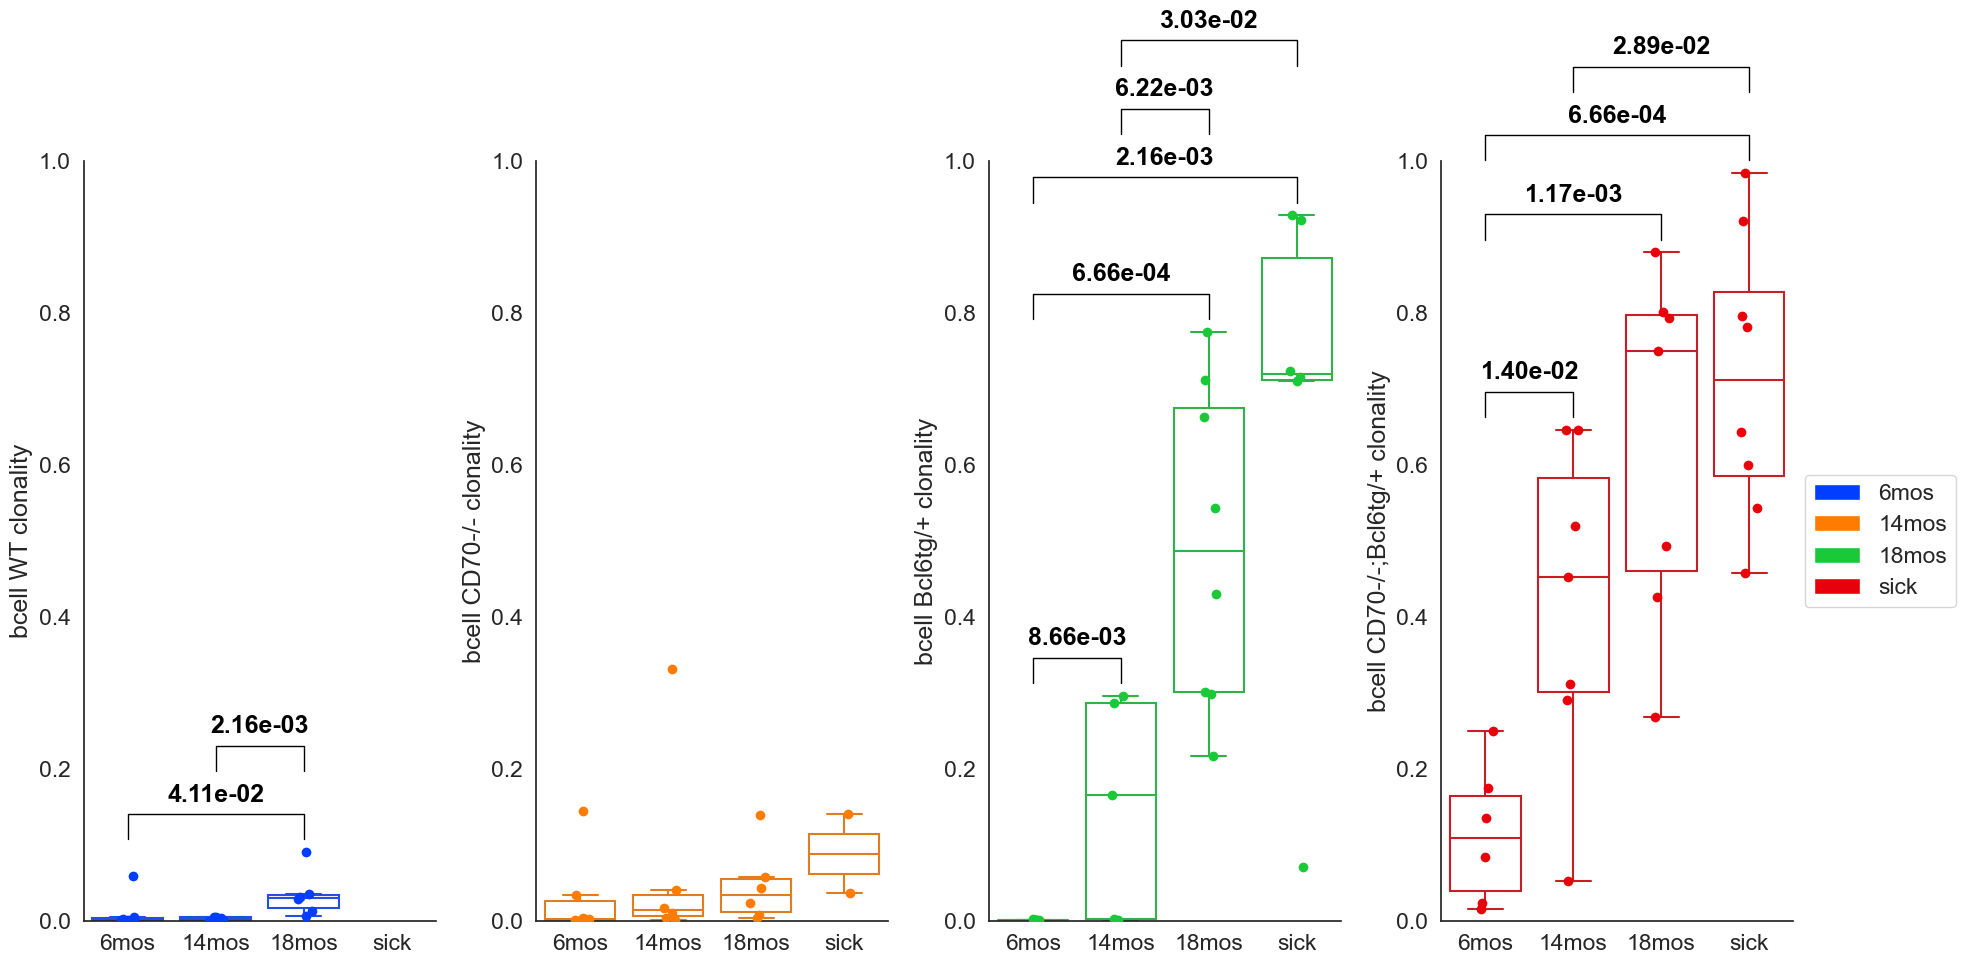

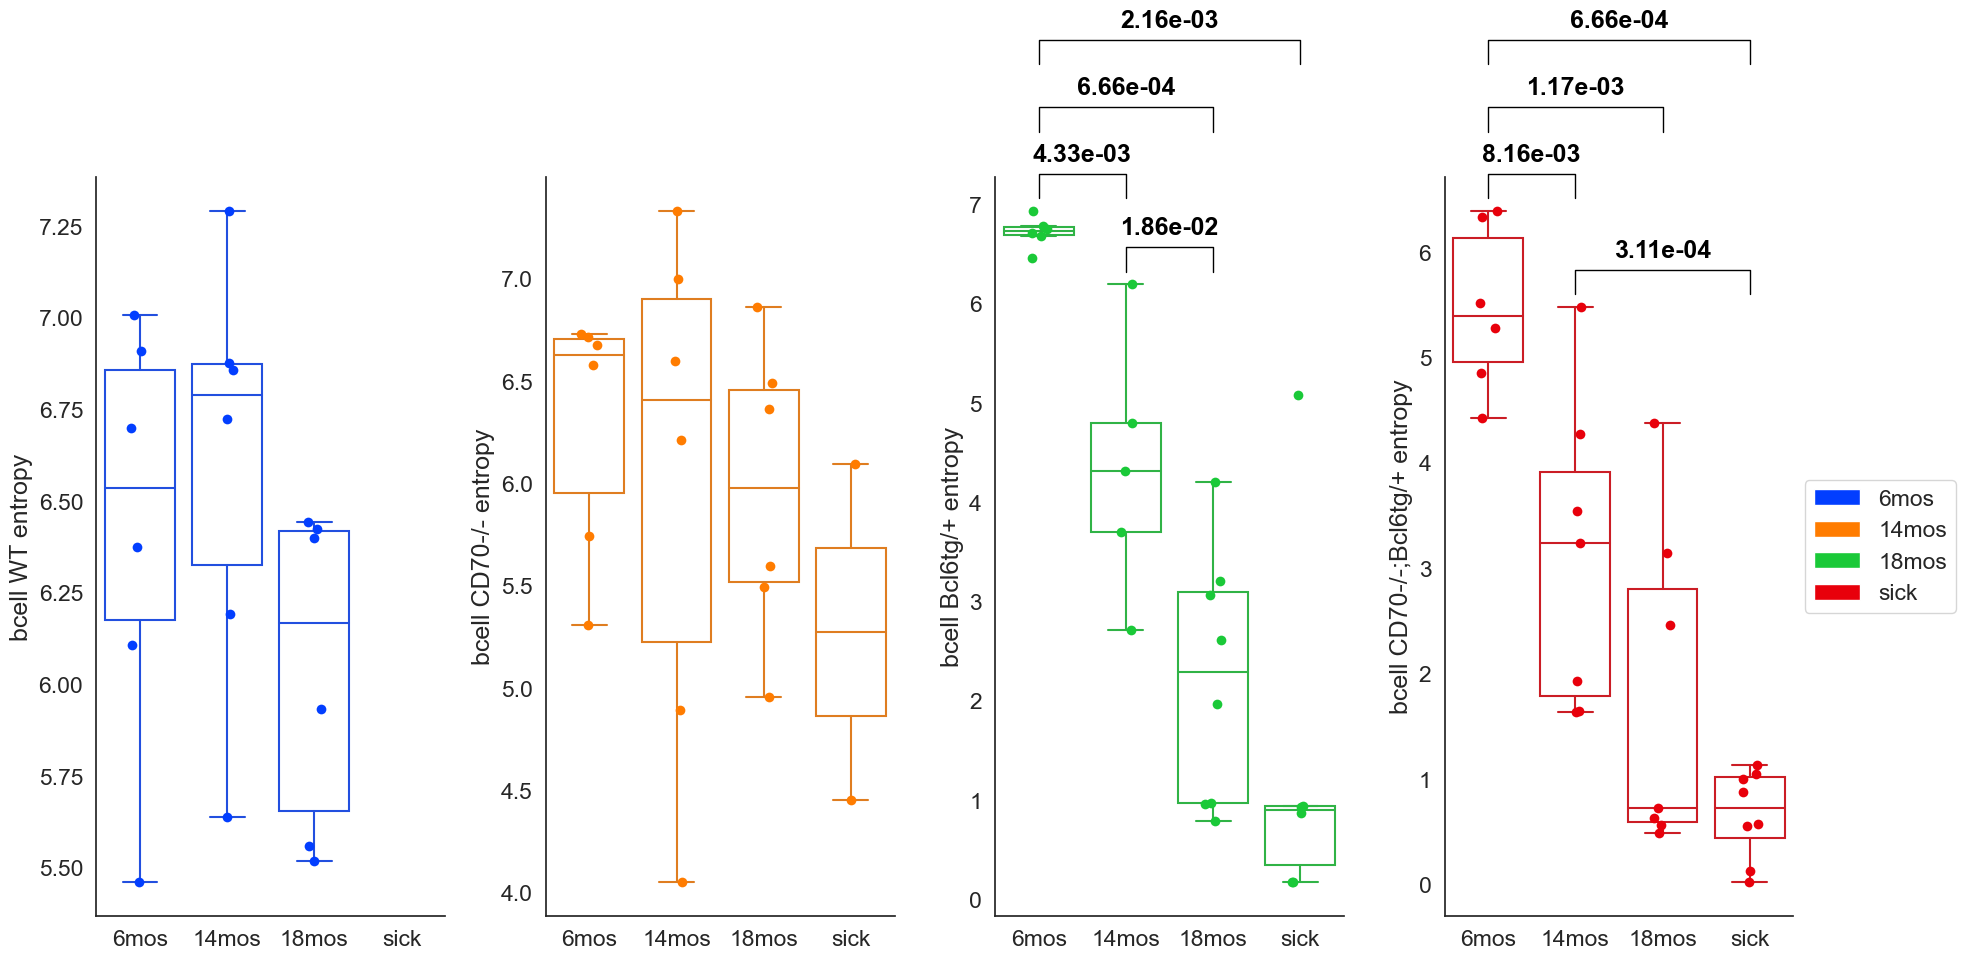

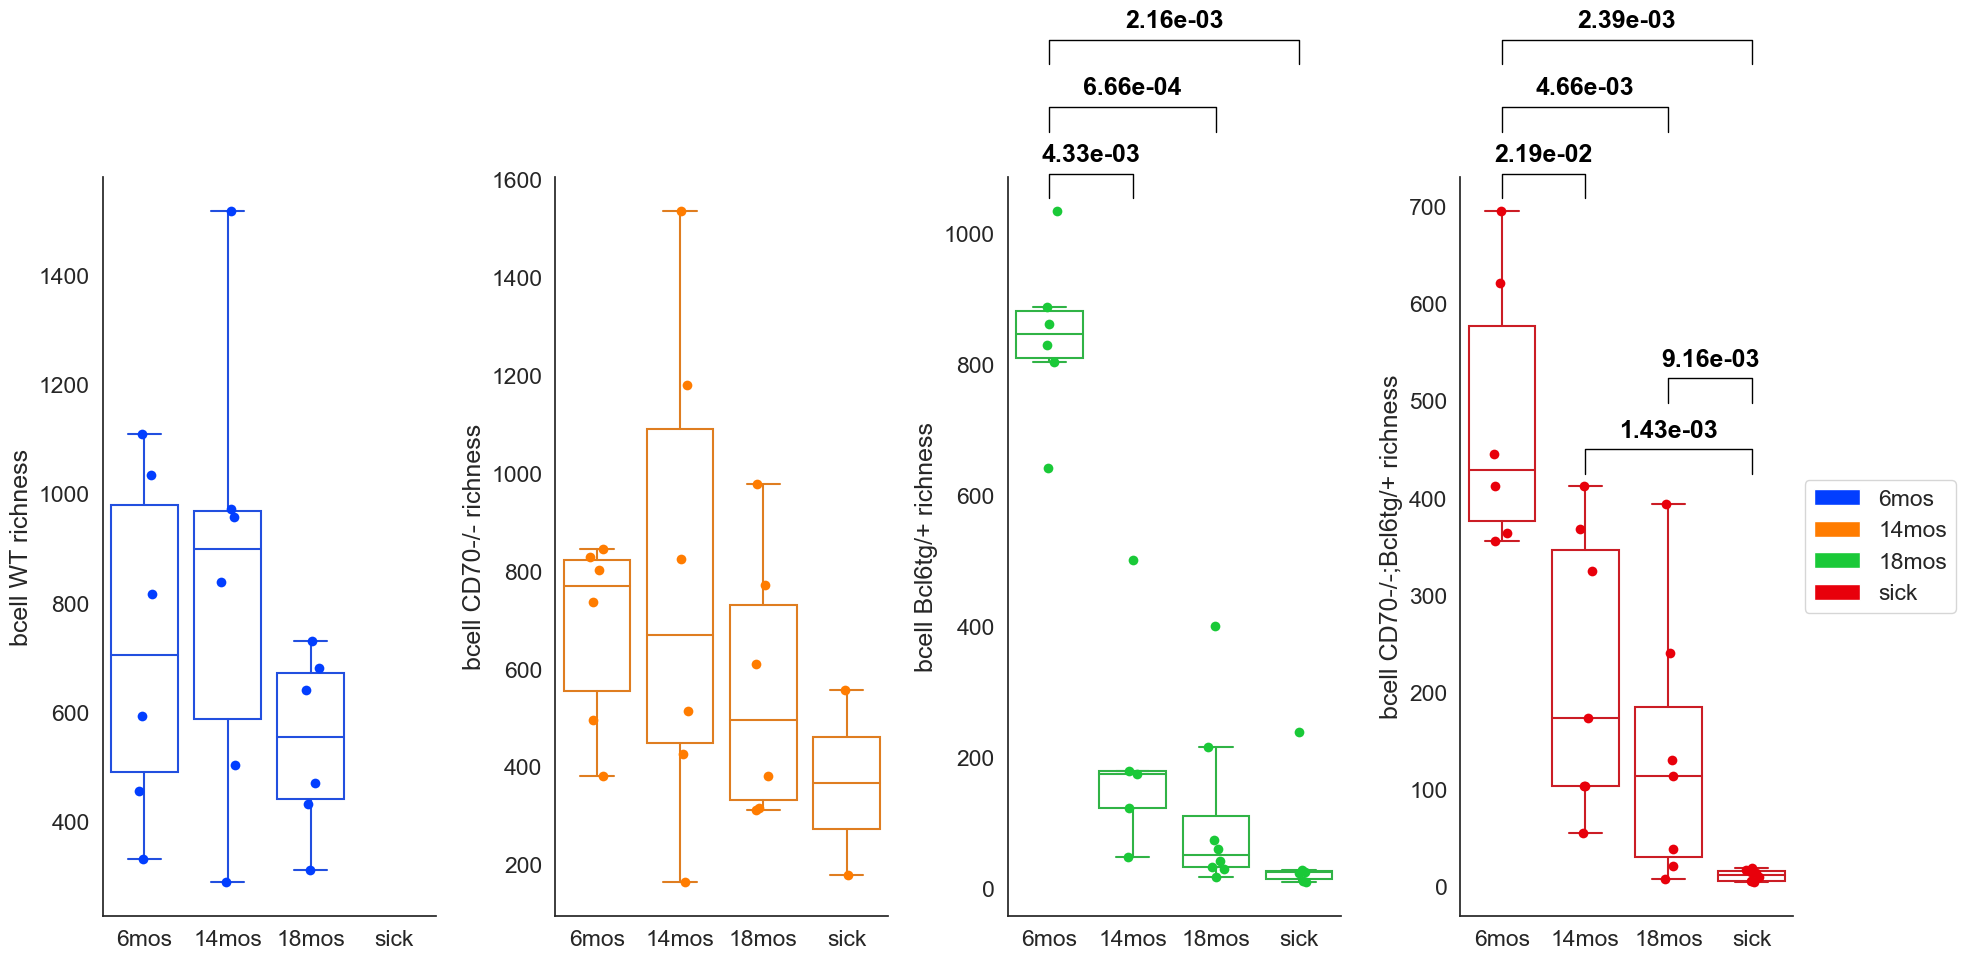

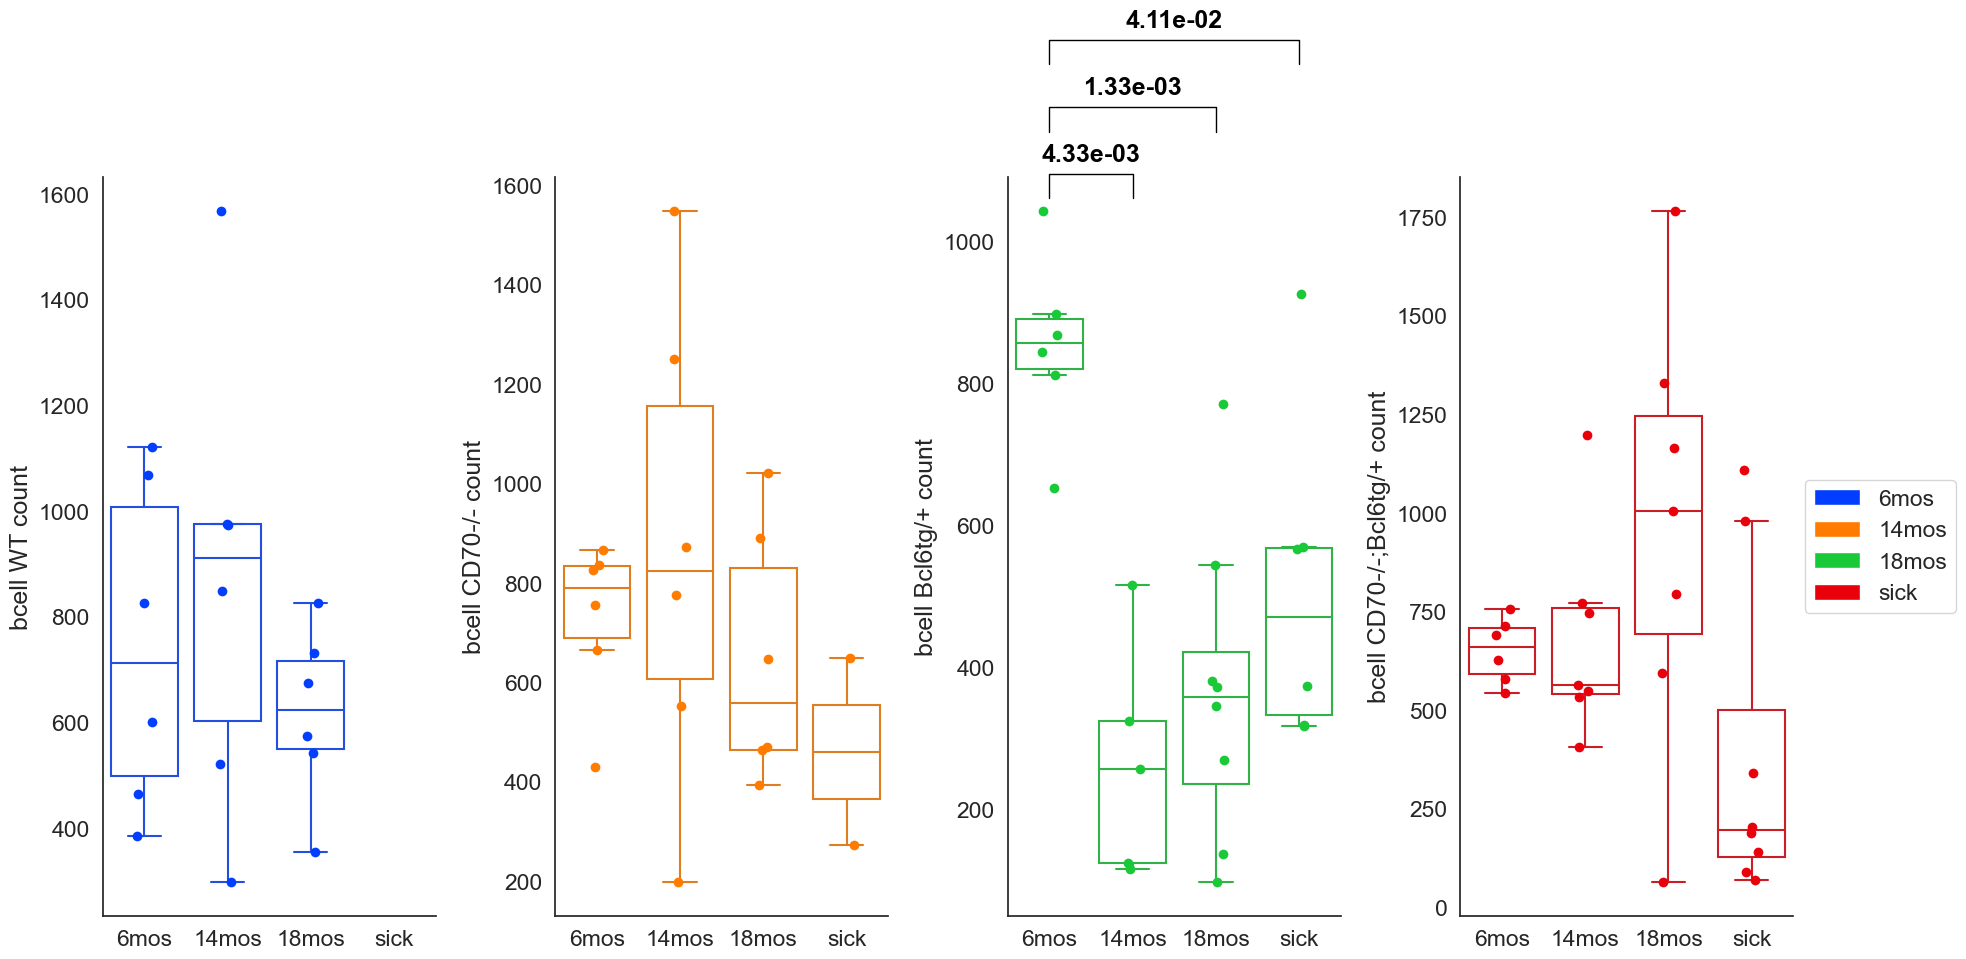

In [ ]:
# metric split by samples, shown in box plots, x-axis ordered by time, do statistical comparison
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
genotypesId = {"WT":0, "CD70-/-":1, "Bcl6tg/+":2, "CD70-/-;Bcl6tg/+":3}
celltype = "bcell" 
#celltype = "cd3_pos_cd4_neg"
#celltype = "cd3_pos_cd8_neg"
#clusterCnt = max(list(sampleClusterDf.loc[sampleClusterDf["celltype"] == celltype]["cluster"])) + 1

# Legend for the barplot
colors = sns.color_palette("bright", len(genotypes))
legend_elements = []
for i, age in enumerate(ages):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=age))

for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    for axIdx, genotype in enumerate(genotypes):
        df = sampleCellTypeDf.loc[(sampleCellTypeDf["celltype"] == celltype) &
                                (sampleCellTypeDf["genotype"] == genotype)]
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "age", y=metric, data=df, ax=ax, 
                   color=colors[axIdx], order=ages, showfliers=False)
        colors = sns.color_palette("bright", len(genotypes))

        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(color)
        
        #handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='age', y=metric, data=df, 
                     ax = ax, dodge=False, order = ages,
                     color=colors[axIdx], size=7)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=legend_elements, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        #ax.set_xticklabels(ages, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(celltype + " " + genotype + " " + metric)
        
        #pairs = []
        #for i in range(len(genotypes) - 1):
        #    pairs.append([genotypes[i], genotypes[3]])
        #pairs.append([genotypes[0], genotypes[2]])
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="age", y=metric, data=df,
                    ax=ax, fig=fig, order = ages, 
                    styles=["bold_significant", "hide_nonsig"], change_ylim=False)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    #plt.title(celltype)
    plt.tight_layout()    
    if (False):
        plt.savefig("SampleCelltype/" + celltype + "_" + metric + "_SampleCelltype_xages_boxplot.pdf", format="pdf")
        

In [53]:
# Output the clonotype information in each celltype
cdr3v = []
countv = []
samplev = []
celltypev = []
for sampleCellType in sampleCellTypeCdr3List:
    cdr3Freq = ConvertToClonotypeFrequency(sampleCellTypeCdr3List[sampleCellType])
    cols = sampleCellType.split(" ")
    for cdr3, freq in cdr3Freq.items():
        cdr3v.append(cdr3)
        countv.append(freq)
        samplev.append(cols[0])
        celltypev.append(cols[1])
df = pd.DataFrame()
df["CDR3aa"] = cdr3v
df["count"] = countv
df["sample"] = samplev
df["celltype"] = celltypev
df.to_csv("clonotype_count_sample_celltype.tsv", sep="\t")

## Selective cluster group comparison

In [ ]:
celltype = "cd3_pos_cd4_neg"
#celltype = "cd3_pos_cd8_neg"
clusterSet = {"2", "3", "8", "13", "16"}
if (celltype == "cd3_pos_cd8_neg"):
    clusterSet = {"1", "4a", "6", "13"}

groupSampleClusterCdr3List = {}
groupSampleClusterInfo = {}
sampleInfo = {}
for sampleCluster, info in sampleClusterInfo.items():
    if (info["celltype"] != celltype
       or str(info["cluster"]) not in clusterSet):
        continue
    sample = sampleCluster.split()[0]
    if (sample not in groupSampleClusterCdr3List):
        groupSampleClusterCdr3List[sample] = []
        groupSampleClusterInfo[sample] = info.copy()
        groupSampleClusterInfo[sample]["size"] = 0
    groupSampleClusterInfo[sample]["size"] += info["size"]    
    groupSampleClusterCdr3List[sample] += sampleClusterCdr3List[sampleCluster]
    
for groupSampleCluster in groupSampleClusterInfo:
    cdr3Freq = ConvertToClonotypeFrequency(groupSampleClusterCdr3List[groupSampleCluster])
    groupSampleClusterInfo[groupSampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["richness"] = ComputeRichness(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["count"] = sum(cdr3Freq.values())
groupSampleClusterDf = pd.DataFrame.from_dict(groupSampleClusterInfo, orient="index")  
groupSampleClusterDf = groupSampleClusterDf[ groupSampleClusterDf["count"] >= 3 ]

groupSampleClusterDf.to_excel("CTL_compartment/" + celltype + "_CTL_diversity.xlsx")

for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    for axIdx, age in enumerate(ages):
        df = groupSampleClusterDf.loc[(groupSampleClusterDf["celltype"] == celltype) &
                                (groupSampleClusterDf["age"] == age)]
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "genotype", y=metric, data=df, ax=ax, 
                   palette="bright", order=genotypes, showfliers=False)
        colors = sns.color_palette("bright", len(genotypes))

        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            k = i
            if (axIdx == 3):
                k = i + 1
            box.set_edgecolor(colors[k%len(genotypes)])
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(colors[k%len(genotypes)])
        
        #handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='genotype', y=metric, data=df, 
                     ax = ax, dodge=False, order = genotypes,
                     palette = "bright", size=7)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=legend_elements, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        ax.set_xticklabels(genotypes, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(age + " " + metric)
        
        pairs = []
        for i in range(len(genotypes) - 1):
            pairs.append([genotypes[i], genotypes[3]])
        pairs.append([genotypes[0], genotypes[2]])
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="genotype", y=metric, data=df,
                    ax=ax, fig=fig, order = genotypes, pairs=pairs,
                    styles=["bold_significant"], change_ylim=False)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    plt.suptitle(celltype)
    plt.tight_layout()    
    if (False):
        plt.savefig("CTL_compartment/" + celltype + " " + metric + "_CTL_boxplot.pdf", format="pdf")
        


In [ ]:
# x-axis is the age
celltype = "cd3_pos_cd4_neg"
celltype = "cd3_pos_cd8_neg"
clusterSet = {"2", "3", "8", "13", "16"}
if (celltype == "cd3_pos_cd8_neg"):
    clusterSet = {"1", "4a", "6", "13"}

groupSampleClusterCdr3List = {}
groupSampleClusterInfo = {}
sampleInfo = {}
for sampleCluster, info in sampleClusterInfo.items():
    if (info["celltype"] != celltype
       or str(info["cluster"]) not in clusterSet):
        continue
    sample = sampleCluster.split()[0]
    if (sample not in groupSampleClusterCdr3List):
        groupSampleClusterCdr3List[sample] = []
        groupSampleClusterInfo[sample] = info.copy()
        groupSampleClusterInfo[sample]["size"] = 0
    groupSampleClusterInfo[sample]["size"] += info["size"]    
    groupSampleClusterCdr3List[sample] += sampleClusterCdr3List[sampleCluster]
    
for groupSampleCluster in groupSampleClusterInfo:
    cdr3Freq = ConvertToClonotypeFrequency(groupSampleClusterCdr3List[groupSampleCluster])
    groupSampleClusterInfo[groupSampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["richness"] = ComputeRichness(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["count"] = sum(cdr3Freq.values())
groupSampleClusterDf = pd.DataFrame.from_dict(groupSampleClusterInfo, orient="index")  
groupSampleClusterDf = groupSampleClusterDf[ groupSampleClusterDf["count"] >= 3 ]

for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    for axIdx, genotype in enumerate(genotypes):
        df = groupSampleClusterDf.loc[(groupSampleClusterDf["celltype"] == celltype) &
                                (groupSampleClusterDf["genotype"] == genotype)]
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "age", y=metric, data=df, ax=ax, 
                   color=colors[axIdx], order=ages, showfliers=False)
        #colors = sns.color_palette("bright", len(genotypes))

        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(color)
        
        #handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='age', y=metric, data=df, 
                     ax = ax, dodge=False, order = ages,
                     color = colors[axIdx], size=7)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=legend_elements, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        #ax.set_xticklabels(ag, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(genotype + " " + metric)
        
        pairs = []
        for i in range(len(genotypes) - 1):
            pairs.append([genotypes[i], genotypes[3]])
        pairs.append([genotypes[0], genotypes[2]])
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="age", y=metric, data=df,
                    ax=ax, fig=fig, order = ages, pairs=None,
                    styles=["bold_significant", "hide_nonsig"], change_ylim=False)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    plt.suptitle(celltype)
    plt.tight_layout()    
    #if (True):
    #    plt.savefig("CTL_compartment/" + celltype + " " + metric + "_xages_CTL_boxplot.pdf", format="pdf")
        


In [ ]:
# x-axis is the age
celltype = "cd3_pos_cd4_neg"
celltype = "cd3_pos_cd8_neg"
clusterSet = {"2", "3", "8", "13", "16"}
if (celltype == "cd3_pos_cd8_neg"):
    clusterSet = {"1", "4a", "6", "13"}

groupSampleClusterCdr3List = {}
groupSampleClusterInfo = {}
sampleInfo = {}
for sampleCluster, info in sampleClusterInfo.items():
    if (info["celltype"] != celltype
       or str(info["cluster"]) not in clusterSet):
        continue
    sample = sampleCluster.split()[0]
    if (sample not in groupSampleClusterCdr3List):
        groupSampleClusterCdr3List[sample] = []
        groupSampleClusterInfo[sample] = info.copy()
        groupSampleClusterInfo[sample]["size"] = 0
    groupSampleClusterInfo[sample]["size"] += info["size"]    
    groupSampleClusterCdr3List[sample] += sampleClusterCdr3List[sampleCluster]
    
for groupSampleCluster in groupSampleClusterInfo:
    cdr3Freq = ConvertToClonotypeFrequency(groupSampleClusterCdr3List[groupSampleCluster])
    groupSampleClusterInfo[groupSampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["richness"] = ComputeRichness(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["count"] = sum(cdr3Freq.values())
groupSampleClusterDf = pd.DataFrame.from_dict(groupSampleClusterInfo, orient="index")  
groupSampleClusterDf = groupSampleClusterDf[ groupSampleClusterDf["count"] >= 3 ]

for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    for axIdx, genotype in enumerate(genotypes):
        df = groupSampleClusterDf.loc[(groupSampleClusterDf["celltype"] == celltype) &
                                (groupSampleClusterDf["genotype"] == genotype)]
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "age", y=metric, data=df, ax=ax, 
                   color=colors[axIdx], order=ages, showfliers=False)
        #colors = sns.color_palette("bright", len(genotypes))

        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(color)
        
        #handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='age', y=metric, data=df, 
                     ax = ax, dodge=False, order = ages,
                     color = colors[axIdx], size=7)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=legend_elements, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        #ax.set_xticklabels(ag, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(genotype + " " + metric)
        
        pairs = []
        for i in range(len(genotypes) - 1):
            pairs.append([genotypes[i], genotypes[3]])
        pairs.append([genotypes[0], genotypes[2]])
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="age", y=metric, data=df,
                    ax=ax, fig=fig, order = ages, pairs=None,
                    styles=["bold_significant", "hide_nonsig"], change_ylim=False)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    plt.suptitle(celltype)
    plt.tight_layout()    
    if (True):
        plt.savefig("CTL_compartment/" + celltype + " " + metric + "_xages_CTL_boxplot.pdf", format="pdf")
        


In [ ]:
## Selected group comparison across two cell type
celltype = "cd3_pos_cd4_neg"
#celltype = "cd3_pos_cd8_neg"
clusterSet = {"2", "3", "8", "13", "16"}
if (celltype == "cd3_pos_cd8_neg"):
    clusterSet = {"1", "4a", "6", "13"}
    
cellTypeGroup = {"cd3_pos_cd4_neg":{"2", "3", "8", "13", "16"},
                "cd3_pos_cd8_neg":{"1", "4a", "6", "13"}}

groupSampleClusterCdr3List = {}
groupSampleClusterInfo = {}
sampleInfo = {}
for sampleCluster, info in sampleClusterInfo.items():
    if (info["celltype"] not in cellTypeGroup
       or str(info["cluster"]) not in cellTypeGroup[info["celltype"]]):
        continue
    sample = sampleCluster.split()[0] + " " + info["celltype"]
    if (sample not in groupSampleClusterCdr3List):
        groupSampleClusterCdr3List[sample] = []
        groupSampleClusterInfo[sample] = info.copy()
        groupSampleClusterInfo[sample]["size"] = 0
    groupSampleClusterInfo[sample]["size"] += info["size"]    
    groupSampleClusterCdr3List[sample] += sampleClusterCdr3List[sampleCluster]
    
for groupSampleCluster in groupSampleClusterInfo:
    cdr3Freq = ConvertToClonotypeFrequency(groupSampleClusterCdr3List[groupSampleCluster])
    groupSampleClusterInfo[groupSampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["richness"] = ComputeRichness(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["count"] = sum(cdr3Freq.values())
groupSampleClusterDf = pd.DataFrame.from_dict(groupSampleClusterInfo, orient="index")  
groupSampleClusterDf = groupSampleClusterDf[ groupSampleClusterDf["count"] >= 3 ]


In [ ]:
for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(25, 10))
    ages = ["6mos", "14mos", "18mos", "sick"]
    genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
    hueOrder = ["cd3_pos_cd4_neg", "cd3_pos_cd8_neg"]
    
    genotypeMap = {"WT":0, "CD70-/-":1, "Bcl6tg/+":2, "CD70-/-;Bcl6tg/+":3}
    for axIdx, age in enumerate(ages):
        df = groupSampleClusterDf.loc[groupSampleClusterDf["age"] == age]
        
        pairs = {}
        for i, row in df.iterrows():
            sample = row["id"]
            if (sample not in pairs):
                pairs[sample] = [[-1, 0], [-1, 0]]
            x = genotypeMap[row["genotype"]]
            tag = 0
            if (row["celltype"] == hueOrder[0]):
                x -= 0.2 
            else:
                x += 0.2
                tag = 1
            y = row[metric]
            pairs[sample][tag] = [x, y]
            
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "genotype", y=metric, data=df, ax=ax, hue = "celltype",
                   palette="bright", order=genotypes, showfliers=False, hue_order=hueOrder)
        colors = sns.color_palette("bright", len(genotypes))
        
        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            k = i
            if (axIdx == 3):
                k = i + 1
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(color)
        
        handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='genotype', y=metric, data=df, hue="celltype",
                     ax = ax, dodge=True, order = genotypes, hue_order=hueOrder,
                     palette = "bright", size=7, jitter=False)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=handles, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        else:
            ax.legend([], frameon=False)
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        ax.set_xticklabels(genotypes, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(age + " " + metric)
        
        for i, p in pairs.items():
            snsFig.plot([p[0][0], p[1][0]], [p[0][1], p[1][1]], "--", color="black", 
                    linewidth=0.5)
        
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="genotype", y=metric, data=df, hue="celltype", pair_test_key="id",
                    ax=ax, fig=fig, order = genotypes, pairs=None, hue_order=hueOrder,
                    styles=["bold_significant"], change_ylim=False,
                    func=sp.stats.wilcoxon)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    #plt.suptitle(age)
    plt.tight_layout()    
    if (True):
        plt.savefig("CTL_compartment/cd4_vs_cd8_" + metric + "_CTL_boxplot_pairtest.pdf", format="pdf")
        

In [ ]:
# Treg (cd8-) and CM/EM (cd4-)
#celltype = "cd3_pos_cd4_neg"
celltype = "cd3_pos_cd8_neg"
    
cellTypeGroup = {"cd3_pos_cd4_neg":{"1", "6", "7"},
                "cd3_pos_cd8_neg":{"3", "7", "10"}}

# Legend for the barplot
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
colors = sns.color_palette("bright", len(genotypes))
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))

groupSampleClusterCdr3List = {}
groupSampleClusterInfo = {}
sampleInfo = {}
for sampleCluster, info in sampleClusterInfo.items():
    if (info["celltype"] not in cellTypeGroup
       or str(info["cluster"]) not in cellTypeGroup[info["celltype"]]):
        continue
    sample = sampleCluster.split()[0] + " " + info["celltype"]
    if (sample not in groupSampleClusterCdr3List):
        groupSampleClusterCdr3List[sample] = []
        groupSampleClusterInfo[sample] = info.copy()
        groupSampleClusterInfo[sample]["size"] = 0
    groupSampleClusterInfo[sample]["size"] += info["size"]    
    groupSampleClusterCdr3List[sample] += sampleClusterCdr3List[sampleCluster]
    
for groupSampleCluster in groupSampleClusterInfo:
    cdr3Freq = ConvertToClonotypeFrequency(groupSampleClusterCdr3List[groupSampleCluster])
    groupSampleClusterInfo[groupSampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["richness"] = ComputeRichness(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["count"] = sum(cdr3Freq.values())
groupSampleClusterDf = pd.DataFrame.from_dict(groupSampleClusterInfo, orient="index")  
groupSampleClusterDf = groupSampleClusterDf[ groupSampleClusterDf["count"] >= 3 ]

groupSampleClusterDf.to_excel("predominant_group/" + celltype + " " + "_predominant_diversity.xlsx")

for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    #hueOrder = ["cd3_pos_cd4_neg", "cd3_pos_cd8_neg"]
    
    genotypeMap = {"WT":0, "CD70-/-":1, "Bcl6tg/+":2, "CD70-/-;Bcl6tg/+":3}
    for axIdx, age in enumerate(ages):
        df = groupSampleClusterDf.loc[(groupSampleClusterDf["age"] == age)
                                     & (groupSampleClusterDf["celltype"] == celltype)]
                   
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "genotype", y=metric, data=df, ax=ax,
                   palette="bright", order=genotypes, showfliers=False)
        colors = sns.color_palette("bright", len(genotypes))
        
        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            k = i
            if (axIdx == 3):
                k = i + 1
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(color)
        
        handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='genotype', y=metric, data=df, hue="genotype",
                     ax = ax, dodge=False, order = genotypes,
                      hue_order = genotypes,
                     palette = "bright", size=7, jitter=False)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=legend_elements, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        else:
            ax.legend([], frameon=False)
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        ax.set_xticklabels(genotypes, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(age + " " + metric)
        
        
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="genotype", y=metric, data=df,
                    ax=ax, fig=fig, order = genotypes,
                    styles=["hide_nonsig"], change_ylim=False)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    plt.suptitle(celltype)
    plt.tight_layout()    
    if (True):
        plt.savefig("predominant_group/" + celltype + " " + metric + "_predominant_boxplot.pdf", format="pdf")
        

In [ ]:
# Treg (cd8-) or CM/EM (cd4-)
# This is almost the same as before, but excluding mouse #256
#celltype = "cd3_pos_cd4_neg"
celltype = "cd3_pos_cd8_neg"
    
cellTypeGroup = {"cd3_pos_cd4_neg":{"1", "6", "7"},
                "cd3_pos_cd8_neg":{"3", "7", "10"}}

# Legend for the barplot
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
colors = sns.color_palette("bright", len(genotypes))
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))

groupSampleClusterCdr3List = {}
groupSampleClusterInfo = {}
sampleInfo = {}
for sampleCluster, info in sampleClusterInfo.items():
    if (info["celltype"] not in cellTypeGroup
       or str(info["cluster"]) not in cellTypeGroup[info["celltype"]]):
        continue
    sample = sampleCluster.split()[0] + " " + info["celltype"]
    if (sample not in groupSampleClusterCdr3List):
        groupSampleClusterCdr3List[sample] = []
        groupSampleClusterInfo[sample] = info.copy()
        groupSampleClusterInfo[sample]["size"] = 0
    groupSampleClusterInfo[sample]["size"] += info["size"]    
    groupSampleClusterCdr3List[sample] += sampleClusterCdr3List[sampleCluster]
    
for groupSampleCluster in groupSampleClusterInfo:
    cdr3Freq = ConvertToClonotypeFrequency(groupSampleClusterCdr3List[groupSampleCluster])
    groupSampleClusterInfo[groupSampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["richness"] = ComputeRichness(cdr3Freq)
    groupSampleClusterInfo[groupSampleCluster]["count"] = sum(cdr3Freq.values())
groupSampleClusterDf = groupSampleClusterDf[ groupSampleClusterDf["count"] >= 3 ]
groupSampleClusterDf = pd.DataFrame.from_dict(groupSampleClusterInfo, orient="index")  

#groupSampleClusterDf.to_excel("predominant_group/" + celltype + " " + "_predominant_diversity.xlsx")

for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    #hueOrder = ["cd3_pos_cd4_neg", "cd3_pos_cd8_neg"]
    
    genotypeMap = {"WT":0, "CD70-/-":1, "Bcl6tg/+":2, "CD70-/-;Bcl6tg/+":3}
    for axIdx, age in enumerate(ages):
        df = groupSampleClusterDf.loc[(groupSampleClusterDf["age"] == age)
                                     & (groupSampleClusterDf["celltype"] == celltype)
                                     & (groupSampleClusterDf["id"] != "256")]
                   
        ax = axes[axIdx]
        snsFig = sns.boxplot(x = "genotype", y=metric, data=df, ax=ax,
                   palette="bright", order=genotypes, showfliers=False)
        colors = sns.color_palette("bright", len(genotypes))
        
        for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
            k = i
            if (axIdx == 3):
                k = i + 1
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor('white')
            #iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                snsFig.lines[j].set_color(color)
        
        handles, labels = ax.get_legend_handles_labels()
        sns.stripplot(x='genotype', y=metric, data=df, hue="genotype",
                     ax = ax, dodge=False, order = genotypes,
                      hue_order = genotypes,
                     palette = "bright", size=7, jitter=False)
        
        #ax.set(title=celltype + " " + age)
        #ax.set_xticks(ticks=list(range(clusterCnt)))
        #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
        if (metric == "clonality"):
            ax.set(ylim=(0, 1))
        if (axIdx == 3):
            ax.legend(handles=legend_elements, loc="center left",
                     bbox_to_anchor=(1, 0.5))
        else:
            ax.legend([], frameon=False)
        #ax.legend(loc="upper right")
        #ax.set_xticks(genotypes)
        ax.set_xticklabels(genotypes, rotation = 30)
        ax.set_xlabel("")
        ax.set_ylabel(age + " " + metric)
        
        
        #pairs.append([genotypes[1], genotypes[2]])
        pvalannot.AddPvalAnnot(x="genotype", y=metric, data=df,
                    ax=ax, fig=fig, order = genotypes,
                    styles=["hide_nonsig"], change_ylim=False)
        
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    plt.suptitle(celltype)
    plt.tight_layout()    
    if (True):
        plt.savefig("predominant_group/" + celltype + " " + metric + "_predominant_boxplot_excludeMouse256.pdf", format="pdf")
        

In [ ]:
# B cell cluster 5 vs all other Cd21/23 low/negative (3,4,7,8,15,22,18,19,21)
cellType = "bcell"
groups = {"C5":{"5"},
         "Other": {"3", "4", "7", "8", "15", "22", "18", "19", "21"}}

# Legend for the barplot
ages = ["6mos", "14mos", "18mos", "sick"]
genotypes = ["WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+"]
colors = sns.color_palette("bright", len(genotypes))
legend_elements = []
for i, g in enumerate(genotypes):
    legend_elements.append(mpatches.Patch(facecolor=colors[i], label=g))

groupSampleClusterCdr3List = {}
groupSampleClusterInfo = {}
sampleInfo = {}
for g in groups:
    for sampleCluster, info in sampleClusterInfo.items():
        if (info["celltype"] not in cellType
           or str(info["cluster"]) not in groups[g]):
            continue
        sample = sampleCluster.split()[0] + " " + g
        if (sample not in groupSampleClusterCdr3List):
            groupSampleClusterCdr3List[sample] = []
            groupSampleClusterInfo[sample] = info.copy()
            groupSampleClusterInfo[sample]["size"] = 0
        groupSampleClusterInfo[sample]["size"] += info["size"]    
        groupSampleClusterCdr3List[sample] += sampleClusterCdr3List[sampleCluster]
        groupSampleClusterInfo[sample]["group"] = g
        
    for groupSampleCluster in groupSampleClusterInfo:
        cdr3Freq = ConvertToClonotypeFrequency(groupSampleClusterCdr3List[groupSampleCluster])
        groupSampleClusterInfo[groupSampleCluster]["clonality"] = ComputeClonality(cdr3Freq)
        groupSampleClusterInfo[groupSampleCluster]["entropy"] = ComputeEntropy(cdr3Freq)
        groupSampleClusterInfo[groupSampleCluster]["richness"] = ComputeRichness(cdr3Freq)
        groupSampleClusterInfo[groupSampleCluster]["count"] = sum(cdr3Freq.values())

groupSampleClusterDf = groupSampleClusterDf[ groupSampleClusterDf["count"] >= 3 ]   
groupSampleClusterDf = pd.DataFrame.from_dict(groupSampleClusterInfo, orient="index")  


for metric in ["clonality", "entropy", "richness", "count"]:
    sns.set(style="white", font_scale=1.5)
    fig = plt.figure(figsize=(5, 5))
    #hueOrder = ["cd3_pos_cd4_neg", "cd3_pos_cd8_neg"]
    df = groupSampleClusterDf
    genotypeMap = {"WT":0, "CD70-/-":1, "Bcl6tg/+":2, "CD70-/-;Bcl6tg/+":3}

    ax = sns.boxplot(x = "group", y=metric, data=df,
               palette="bright", order=["C5", "Other"], showfliers=False)
    colors = sns.color_palette("bright", len(genotypes))

    for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
        k = i
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor('white')
        #iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            ax.lines[j].set_color(color)

    handles, labels = ax.get_legend_handles_labels()
    sns.stripplot(x='group', y=metric, data=df,
                 ax = ax, dodge=False, order = ["C5", "Other"],
                 palette = "bright", size=7, jitter=True)

    #ax.set(title=celltype + " " + age)
    #ax.set_xticks(ticks=list(range(clusterCnt)))
    #ax.set_xticklabels([str(i) for i in range(clusterCnt)])
    if (metric == "clonality"):
        ax.set(ylim=(0, 1.05))
    #if (axIdx == 3):
    #    ax.legend(handles=legend_elements, loc="center left",
    #             bbox_to_anchor=(1, 0.5))
    #else:
    #    ax.legend([], frameon=False)
    #ax.legend(loc="upper right")
    #ax.set_xticks(genotypes)
    #ax.set_xticklabels(genotypes, rotation = 30)
    ax.set_xlabel("")
    #ax.set_ylabel(age + " " + metric)


    #pairs.append([genotypes[1], genotypes[2]])
    pvalannot.AddPvalAnnot(x="group", y=metric, data=df,
                ax=ax, fig=fig, order = ["C5", "Other"],
                styles=["hide_nonsig"], change_ylim=False)

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    plt.suptitle(cellType)
    plt.tight_layout()    
    if (True):
        plt.savefig("bcell/C5vsOther" + " " + metric + "_boxplot.pdf", format="pdf")
        